# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [1]:
# Common libraries
import inspect
import numpy as np 
import pandas as pd 
from scipy.stats import norm 
import os

# Models
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Selection classifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss)

# Simulation functions
from sklearn.datasets import make_classification, make_blobs


# Visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Data
from sklearn.datasets import load_iris





In [2]:
# SETRED
import sys
sys.path.append(os.path.abspath(".."))
from setred_package import setred_scratch, simulated_data,  setred_scratch_v2
from utils.adspy_shared_utilities import plot_class_regions_for_classifier

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

In [3]:
# Parameters of the simulation
n = 13000  # Number of samples
K = 5      # Number of classes
p = 5     # Number of features

X = np.load("../data/X.npy")
y = np.load("../data/y.npy")
X_unlabel = np.load("../data/X_unlabel.npy")
y_unlabel = np.load("../data/y_unlabel.npy")
X_ori = np.load("../data/X_ori.npy")
y_ori = np.load("../data/y_ori.npy")
X_test = np.load("../data/X_test.npy")
y_test = np.load("../data/y_test.npy")

In [4]:
colors =    [ 
    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
    '#00FFFF',  # Cyan / Aqua
]

cmap_bold = ListedColormap(colors = colors)

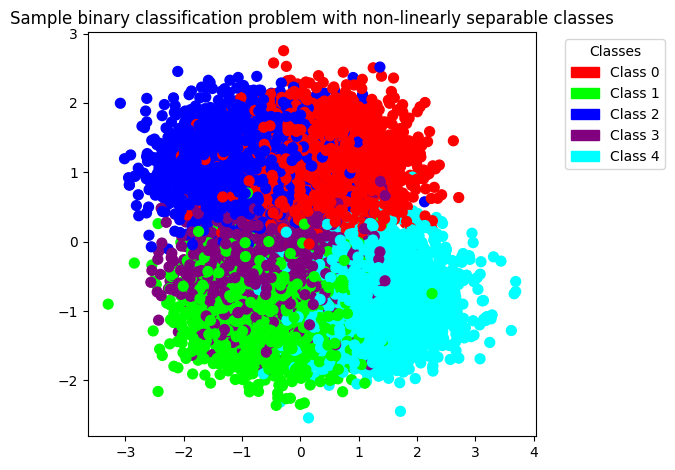

In [5]:
import matplotlib.patches as mpatches
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_ori[:,0], X_ori[:,1], c=y_ori,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_ori)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Artificial semisupervised learning data


In [6]:
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the shape of the test datasets
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y: {pd.Series(y).value_counts(normalize=False)}")


Shape of X: (13600, 5), y: (13600,), X_unlabel: (13464, 5), y_unlabel: (13464,)
Shape of X_test: (3400, 5), y_test: (3400,)
Frequencies of classes in y: -1    13464
 0       40
 4       25
 1       24
 3       24
 2       23
Name: count, dtype: int64


In [7]:
# Filtering the labeled instances
X_val = X[y != -1]
y_val = y[y != -1]
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val: {pd.Series(y_val).value_counts(normalize=False)}")
print(f"Frequencies of classes in y_test: {pd.Series(y_test).value_counts(normalize=False)}")


Shape of X_val: (136, 5), y_val: (136,), X_test: (3400, 5), y_test: (3400,)
Frequencies of classes in y_val: 0    40
4    25
1    24
3    24
2    23
Name: count, dtype: int64
Frequencies of classes in y_test: 1    680
4    680
2    680
3    680
0    680
Name: count, dtype: int64


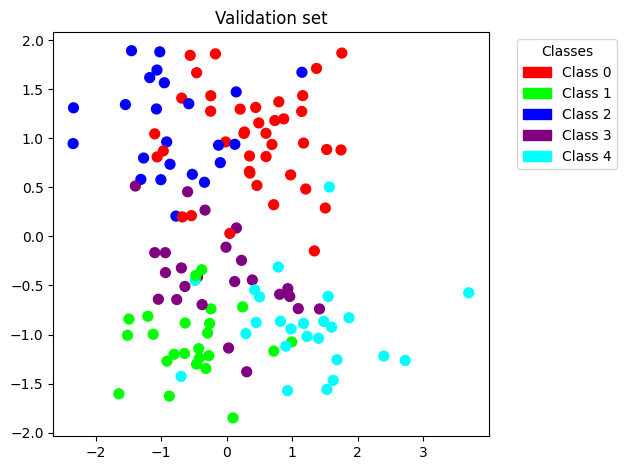

In [8]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_val)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


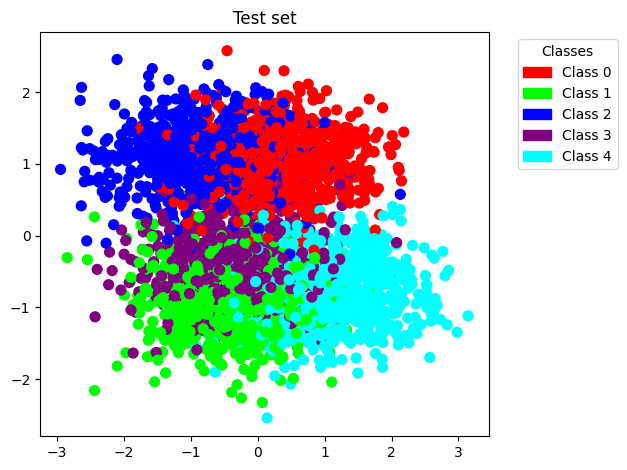

In [9]:
plt.figure()
plt.title('Test set')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_test)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/b9/3rhyw3yn6xj6wh63pjfz16100000gn/T/ipykernel_28698/1907776411.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_unlabel[:,0], X_unlabel[:,1], c='grey',


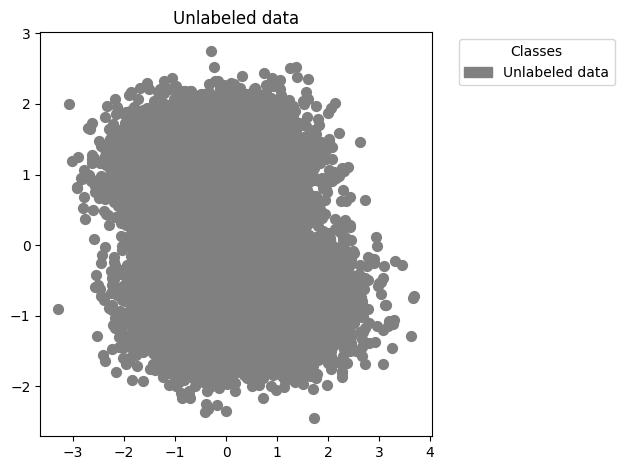

In [10]:
# plot unlabeled data
plt.figure()
plt.title('Unlabeled data')
plt.scatter(X_unlabel[:,0], X_unlabel[:,1], c='grey',
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_unlabel)
patches = [mpatches.Patch(color='grey', label='Unlabeled data')]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# K nearest neighbours

In [11]:
knn = KNeighborsClassifier()
# Hyperparameters for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9,15,20],
    'weights': ['distance'],
    'p': [2],  # 1 = Manhattan, 2 = Euclidean
    'metric': ['euclidean']
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_knn = KNeighborsClassifier(**best_params)
#base_estimator_knn = KNeighborsClassifier(metric='euclidean', n_neighbors=20, p=2, weights='distance')
base_estimator_knn.fit(X_val, y_val)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')

# Metrics of the base estimator

In [12]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_knn.predict(X_val)
y_test_pred = base_estimator_knn.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 1.0
Accuracy of the base estimator on the test set: 0.846764705882353
Classification report on validation set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        25

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136

Classification report on test set:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       680
           1       0.89      0.94      0.91       680
           2       0.88      0.85      0.86       680
           3       0.79      0.69      0.73       680
           4       0.87      0.87      0

In [13]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_knn.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))

Accuracy of the base estimator on the unlabeled set: 0.8551693404634582
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2680
           1       0.89      0.95      0.92      2696
           2       0.88      0.85      0.87      2697
           3       0.80      0.72      0.76      2696
           4       0.88      0.87      0.88      2695

    accuracy                           0.86     13464
   macro avg       0.85      0.86      0.85     13464
weighted avg       0.85      0.86      0.85     13464



In [14]:
from sklearn.metrics import  accuracy_score
accuracy_score(y_unlabel, y_unlabel_pred,sample_weight=None)

0.8551693404634582

# SETRED CLASSIFIER

In [15]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## KNN SETRED

In [30]:
ssl_clf_knn = setred_scratch.Setred_scratch(    
                            base_estimator=base_estimator_knn,
                            graph_neighbors=10,
                            max_iterations=10,                             
                            htunning=True,
                            param_grid={
                                        'n_neighbors': [ 2,5,7,10, 15, 20],
                                        'weights': ['distance', 'uniform'],
                                        'p': [2],  # 1 = Manhattan, 2 = Euclidean
                                        'metric': ['euclidean']
                                            },
                            X_test =X_test, # This is a matrix with the test instances to evaluate the model.
                            y_test=y_test,
                            y_real_label = y_unlabel,                            
                            view =10)
ssl_clf_knn.fit(X, y)


---------------------------------------------------------------
-------------------Iteration 10 Started ------------
---------------------------------------------------------------
Distribution of real classes in the unlabeled set:
0    32
1    30
2    31
3    20
4    23
Name: count, dtype: int64
Distribution of the first  pseudolabel (predicted) candidates in the unlabeled set:
0    38
1    31
2    27
3    17
4    23
Name: count, dtype: int64
--------------------------------------------------------------
------Verification after filtering (Cut Edge Statistic)-------
--------------------------------------------------------------
Comparison between the filtered pseudolabels and the real labels of the unlabeled instances
Distribution of real classes in the unlabeled set:
0    32
1    30
2    31
3    20
4    23
Name: count, dtype: int64
Distribution of the filtered pseudolabels in the unlabeled set:
0    38
1    31
2    27
3    17
4    23
Name: count, dtype: int64
Iteration 10 - Accuracy:

Setred_scratch(X_test=array([[ 0.76265707, -0.9782696 ,  0.38984097, -0.29717653,  1.60650522],
       [ 0.46809851, -0.98903835,  0.82674711,  0.75384018,  0.80657413],
       [ 1.16941369, -1.32147955, -2.12202369, -1.87076809,  0.39791259],
       ...,
       [ 0.29886737, -0.52327837, -1.49256919,  0.29601702,  0.58883689],
       [-0.03174198, -0.64202884, -0.30770395,  0.65051042, -0.00426793],
       [ 1.14954041, -0.186781....58956171,  0.25613887]]),
               base_estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=9,
                                                   weights='distance'),
               graph_neighbors=10, htunning=True, max_iterations=10,
               param_grid={'metric': ['euclidean'],
                           'n_neighbors': [2, 5, 7, 10, 15, 20], 'p': [2],
                           'weights': ['distance', 'uniform']},
               view=10, y_real_label=array([2, 3, 1, ..., 3, 0, 0]),
               y_test=array([1, 1, 4, ..., 3, 4, 4]))

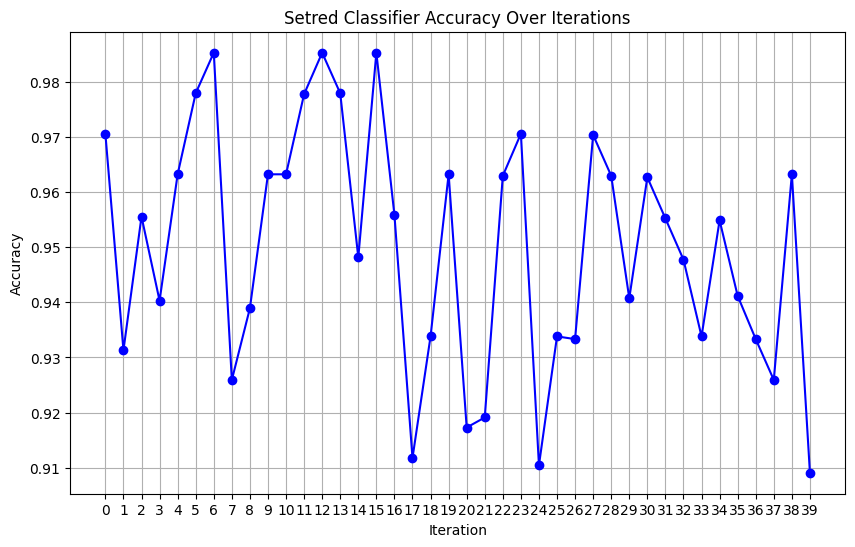

In [25]:
# Plot the accuracy of the Setred classifier
plt.figure(figsize=(10, 6))
plt.plot(ssl_clf_knn.accuracy_, marker='o', linestyle='-', color='b')
plt.title('Setred Classifier Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(len(ssl_clf_knn.accuracy_)))
plt.grid()


# Evaluation metrics

## Test

In [31]:
# Accuracy score
## Base setimiator
y_pred = base_estimator_knn.predict(X_test)
accuracy_score_dt = base_estimator_knn.score(X_test, y_test)
print(f"Accuracy of the base estimator on the test set: {accuracy_score_dt}")
accuracy_score_setred = ssl_clf_knn.score(X_test, y_test)
print(f"Accuracy of the Setred classifier on the test set: {accuracy_score_setred}")
# The difference between the base estimator and the Setred classifier
print(f"Difference between the base estimator and the Setred classifier: {accuracy_score_setred - accuracy_score_dt}")
# The percentage of improvement
improvement = ((accuracy_score_setred - accuracy_score_dt )/ accuracy_score_dt) * 100
print(f"Percentage of improvement: {improvement:.2f}%")


Accuracy of the base estimator on the test set: 0.846764705882353
Accuracy of the Setred classifier on the test set: 0.8288235294117647
Difference between the base estimator and the Setred classifier: -0.017941176470588238
Percentage of improvement: -2.12%


In [32]:
# Generate predictions on the test set
y_pred = base_estimator_knn.predict(X_test)
# Generate the classification report
print("Classification report on test set with Base estimator:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set with Base estimator:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       680
           1       0.89      0.94      0.91       680
           2       0.88      0.85      0.86       680
           3       0.79      0.69      0.73       680
           4       0.87      0.87      0.87       680

    accuracy                           0.85      3400
   macro avg       0.85      0.85      0.85      3400
weighted avg       0.85      0.85      0.85      3400



In [33]:
# Generate predictions on the test set
y_pred = ssl_clf_knn.predict(X_test)
# Generate the classification report
print("Classification report on test set with Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set with Setred:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       680
           1       0.85      0.95      0.90       680
           2       0.87      0.81      0.84       680
           3       0.80      0.59      0.68       680
           4       0.86      0.88      0.87       680

    accuracy                           0.83      3400
   macro avg       0.83      0.83      0.82      3400
weighted avg       0.83      0.83      0.82      3400



## Unlabel

In [34]:
# Accuracy score
## Base setimiator
y_pred = base_estimator_knn.predict(X_unlabel)
accuracy_score_dt = base_estimator_knn.score(X_unlabel, y_unlabel)
print(f"Accuracy of the base estimator on the test set: {accuracy_score_dt}")
accuracy_score_setred = ssl_clf_knn.score(X_unlabel, y_unlabel)
print(f"Accuracy of the Setred classifier on the test set: {accuracy_score_setred}")
# The difference between the base estimator and the Setred classifier
print(f"Difference between the base estimator and the Setred classifier: {accuracy_score_setred - accuracy_score_dt}")
# The percentage of improvement
improvement = ((accuracy_score_setred - accuracy_score_dt )/ accuracy_score_dt) * 100
print(f"Percentage of improvement: {improvement:.2f}%")

Accuracy of the base estimator on the test set: 0.8551693404634582
Accuracy of the Setred classifier on the test set: 0.8415775401069518
Difference between the base estimator and the Setred classifier: -0.013591800356506312
Percentage of improvement: -1.59%


In [35]:
# Generate predictions on the test set
y_pred = base_estimator_knn.predict(X_unlabel)
# Generate the classification report
print("Classification report on test set with base estimator:")
report = classification_report(y_unlabel, y_pred)
print(report)

Classification report on test set with base estimator:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2680
           1       0.89      0.95      0.92      2696
           2       0.88      0.85      0.87      2697
           3       0.80      0.72      0.76      2696
           4       0.88      0.87      0.88      2695

    accuracy                           0.86     13464
   macro avg       0.85      0.86      0.85     13464
weighted avg       0.85      0.86      0.85     13464



In [36]:
# Generate predictions on the test set
y_pred = ssl_clf_knn.predict(X_unlabel)
# Generate the classification report
print("Classification report on test set with Setred:")
report = classification_report(y_unlabel, y_pred)
print(report)

Classification report on test set with Setred:
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      2680
           1       0.84      0.96      0.89      2696
           2       0.89      0.82      0.85      2697
           3       0.81      0.64      0.72      2696
           4       0.88      0.88      0.88      2695

    accuracy                           0.84     13464
   macro avg       0.84      0.84      0.84     13464
weighted avg       0.84      0.84      0.84     13464

